reference: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

## Title: Sentiment Analysis in Social Media Text using Neural Network <a class="anchor" id="intro"></a>

Description:

In this project, two most frequently used machine learning algorithms, which are Multinomial Naïve Bayes and Logistic Regression machine learning algorithm, are used to compare with the proposed method. 

To improve the performance of machine learning model, Stratified K-Fold cross validation is used to cross validate class imbalance dataset

### Table of Content

* [Introduction](#intro)
	* [Set-up environment](#set_up)
	* [Load Dataset](#load_data)
	* [Drop Duplicate Rows](#drop_row)
	* [Categorical Target Conversion](#convert_target)
* [Word Embedding - BOW](#word_emb)
	* [Logistic Regression + BOW](#bow_lr)
* [Word Embedding - TF-IDF](#tfidf_emb)
	* [Naive Bayes + TF-IDF](#tfidf_nb)

#### Set-up Environment <a class="anchor" id="setup"></a>

In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.model_selection import StratifiedKFold
## for explainer
from lime.lime_text import LimeTextExplainer
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#### Load Dataset <a class="anchor" id="load_data"></a>

In [2]:
texts = pd.read_csv('3 classes/facebook_health_cases (all).csv')
df = pd.DataFrame(texts)
df

,date,text,sentiment,processed,normalized,check,check_stop
0,20210221,#dsnr salam dato.. lebih kurang 15km dari ruma...,negative,salam dato lebih kurang km dari rumah ke kila...,salam dato lebih kurang km dari rumah ke kilan...,salam dato lebih kurang kkm dari rumah ke kila...,kurang kkm rumah ke kilang pkp pkb pkpp tidak ...
1,20210204,#noorhishamabdullah you’re not dr.fauci materi...,negative,you re not dr fauci material you re just pn gr...,you re not dr fauci material you re just pun g...,you re not dr fauci material you re just pun g...,not fauci material grabmart boy
2,20210130,#share dan #like page #the_information_news un...,neutral,dan page untuk mendapatkan khabar berita yang ...,dan page untuk mendapatkan khabar berita yang ...,dan page untuk mendapatkan khabar berita yang ...,page khabar berita saudara patani selatan thai...
3,20210202,1 dunia sedang & terus diperbodohkan dgn agend...,negative,satu dunia sedang and terus diperbodohkan dgn ...,satu dunia sedang and terus diperbodohkan deng...,satu dunia sedang and terus diperbodohkan deng...,dunia diperbodohkan agenda yahudi ekonomi duni...
4,20210206,1 hari sy harap angka nie turun single digit m...,positive,satu hari sy harap angka nie turun single digi...,satu hari sy harap angka ini turun single digi...,satu hari sy harap angka ini turun single digi...,harap angka turun single digit capai zero case...
...,...,...,...,...,...,...,...
7902,20210121,wish,positive,wish,wish,wish,wish
7903,20210123,ya allah.. sy rasa satu pkra kita terlepas pan...,positive,ya allah sy rasa satu pkra kita terlepas panda...,ya allah sy rasa satu pkra kita terlepas panda...,ya allah sy rasa satu pkra kita terlepas panda...,pkra terlepas pandang lupa solat hajat bacaan ...
7904,20210124,ya allah mari kita brdoa bnyk2 smoga allah amp...,positive,ya allah mari kita brdoa bnyk smoga allah amp...,ya allah mari kita brdoa banyak semoga allah a...,ya allah mari kita berdoa banyak semoga allah ...,mari berdoa banyak semoga ampunkan dosa harap ...
7905,20210125,yaallah ya tuhan ku sembuhkan la semua pesakit...,positive,yaallah ya tuhan ku sembuhkan la semua pesakit...,yaal lah ya tuhan ku sembuhkan la semua pesaki...,yaal lah ya tuhan aku sembuhkan la semua pesak...,tuhan sembuhkan pesakit covid tuhan lindungi k...


#### Drop Duplicate Row(s) <a class="anchor" id="drop_row"></a>

In [3]:
# remove possible empty text cell
print("before cleaned: ", df.shape)
df['check_stop'].replace('', np.nan, inplace=True)
df = df.dropna()
df = df.reset_index(drop=True)
print("After: ", df.shape)

before cleaned:  (7907, 7)
After:  (7905, 7)


#### Categorical Target Conversion   <a class="anchor" id="convert_target"></a>

*cat.codes* is a function from library Panda that convert categorical value to numeric value. In this project, the target values that has been converted are:
- negative -> 0
- neutral -> 1
- positive -> 2

In [4]:
# Map the sentiment into 0 , 1, 2
df['sentiment'] = df['sentiment'].map({'positive':2, 'negative':0, 'neutral':1})

Check first five rows after conversion

In [5]:
df.head()

,date,text,sentiment,processed,normalized,check,check_stop
0,20210221,#dsnr salam dato.. lebih kurang 15km dari ruma...,0,salam dato lebih kurang km dari rumah ke kila...,salam dato lebih kurang km dari rumah ke kilan...,salam dato lebih kurang kkm dari rumah ke kila...,kurang kkm rumah ke kilang pkp pkb pkpp tidak ...
1,20210204,#noorhishamabdullah you’re not dr.fauci materi...,0,you re not dr fauci material you re just pn gr...,you re not dr fauci material you re just pun g...,you re not dr fauci material you re just pun g...,not fauci material grabmart boy
2,20210130,#share dan #like page #the_information_news un...,1,dan page untuk mendapatkan khabar berita yang ...,dan page untuk mendapatkan khabar berita yang ...,dan page untuk mendapatkan khabar berita yang ...,page khabar berita saudara patani selatan thai...
3,20210202,1 dunia sedang & terus diperbodohkan dgn agend...,0,satu dunia sedang and terus diperbodohkan dgn ...,satu dunia sedang and terus diperbodohkan deng...,satu dunia sedang and terus diperbodohkan deng...,dunia diperbodohkan agenda yahudi ekonomi duni...
4,20210206,1 hari sy harap angka nie turun single digit m...,2,satu hari sy harap angka nie turun single digi...,satu hari sy harap angka ini turun single digi...,satu hari sy harap angka ini turun single digi...,harap angka turun single digit capai zero case...


In order to understand the composition of the dataset, I am going to look into the univariate distribution of the target by showing labels frequency with a bar plot.

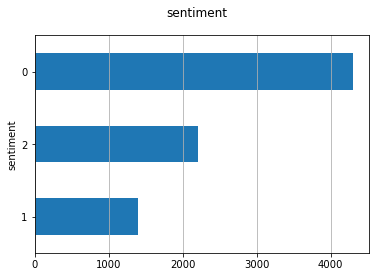

In [6]:
fig, ax = plt.subplots()
fig.suptitle("sentiment", fontsize=12)
df["sentiment"].reset_index().groupby("sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
## split dataset
# X = df.drop(['sentiment'], axis=1)
# y = df.sentiment
# dtf_train, dtf_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### BOW and TFIDF

In [8]:
## Count (classic BoW)
# vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
#vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# both capture unigram and bigram

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        7905 non-null   int64 
 1   text        7905 non-null   object
 2   sentiment   7905 non-null   int64 
 3   processed   7905 non-null   object
 4   normalized  7905 non-null   object
 5   check       7905 non-null   object
 6   check_stop  7905 non-null   object
dtypes: int64(2), object(5)
memory usage: 432.4+ KB


#### Lime Visualizer

source: https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html

In [10]:
# vectorizer + model evaluation + lime (all in one :D)
def ml_plot(corpus, model, split_percent, limee=False): 
    X = corpus.check_stop
    y = corpus.sentiment
    
    
    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    lst_accu_stratified = []
    
    for train_index, test_index in skf.split(X, y):
        vectorizer = feature_extraction.text.CountVectorizer(max_features=10000) #bigram
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        X_train = vectorizer.fit_transform(x_train_fold)
        X_test = vectorizer.transform(x_test_fold)
        clf = model
        clf.fit(X_train, y_train_fold)
        lst_accu_stratified.append(clf.score(X_test, y_test_fold))

    #clf = model
    #clf['classifier'].fit(X_train, y_train)
    #prediction = clf.predict(X_test_ori)
    #predicted_prob = clf.predict_proba(X_test_ori)
    accuracy = np.array(lst_accu_stratified)
    print('\nMax Accuracy:', max(lst_accu_stratified)*100, '%')
    print('\nAverage Accuracy:', np.mean(accuracy))

#### Logistic Regression + BOW <a class="anchor" id="bow_lr"></a>

In [13]:
ml_plot(df, LogisticRegression(max_iter=1000), .02, limee=True)


Max Accuracy: 75.85335018963337 %

Average Accuracy: 0.7447195506409129


In [19]:
# vectorizer + model evaluation + lime (all in one :D)
def ml_plot_tfidf(corpus, model, split_percent, limee=False): 
    X = corpus.check_stop
    y = corpus.sentiment
    
    
    # Create StratifiedKFold object.
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    lst_accu_stratified = []
    
    for train_index, test_index in skf.split(X, y):
        vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000)
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        X_train = vectorizer.fit_transform(x_train_fold)
        X_test = vectorizer.transform(x_test_fold)
        clf = model
        clf.fit(X_train, y_train_fold)
        lst_accu_stratified.append(clf.score(X_test, y_test_fold))

    #clf = model
    #clf['classifier'].fit(X_train, y_train)
    #prediction = clf.predict(X_test_ori)
    #predicted_prob = clf.predict_proba(X_test_ori)
    accuracy = np.array(lst_accu_stratified)
    print('\nMax Accuracy:', max(lst_accu_stratified)*100, '%')
    print('\nAverage Accuracy:', np.mean(accuracy))

#### Naive Bayes + TF-IDF <a class="anchor" id="tfidf_nb"></a>

In [20]:
m = ml_plot_tfidf(df, MultinomialNB(), .02, limee=True)


Max Accuracy: 73.79746835443038 %

Average Accuracy: 0.7299198258893567
